In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [3]:
# Define image size and batch size
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# Set the directories for training, validation, and test datasets
base_dir = 'cats_and_dogs'
TRAIN_DIR = os.path.join(base_dir, 'train')
VALIDATION_DIR = os.path.join(base_dir, 'validation')
TEST_DIR = os.path.join(base_dir, 'test')


In [4]:
# Create a basic ImageDataGenerator for rescaling only
basic_datagen = ImageDataGenerator(rescale=1./255)

# For training and validation, use flow_from_directory with proper labels
train_data_gen = basic_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_data_gen = basic_datagen.flow_from_directory(
    directory=VALIDATION_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# For test data, note that there is only one folder.
# Since test images are unlabeled, set class_mode=None and disable shuffling.
test_data_gen = basic_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,  # Predict one image at a time
    class_mode=None,
    shuffle=False
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


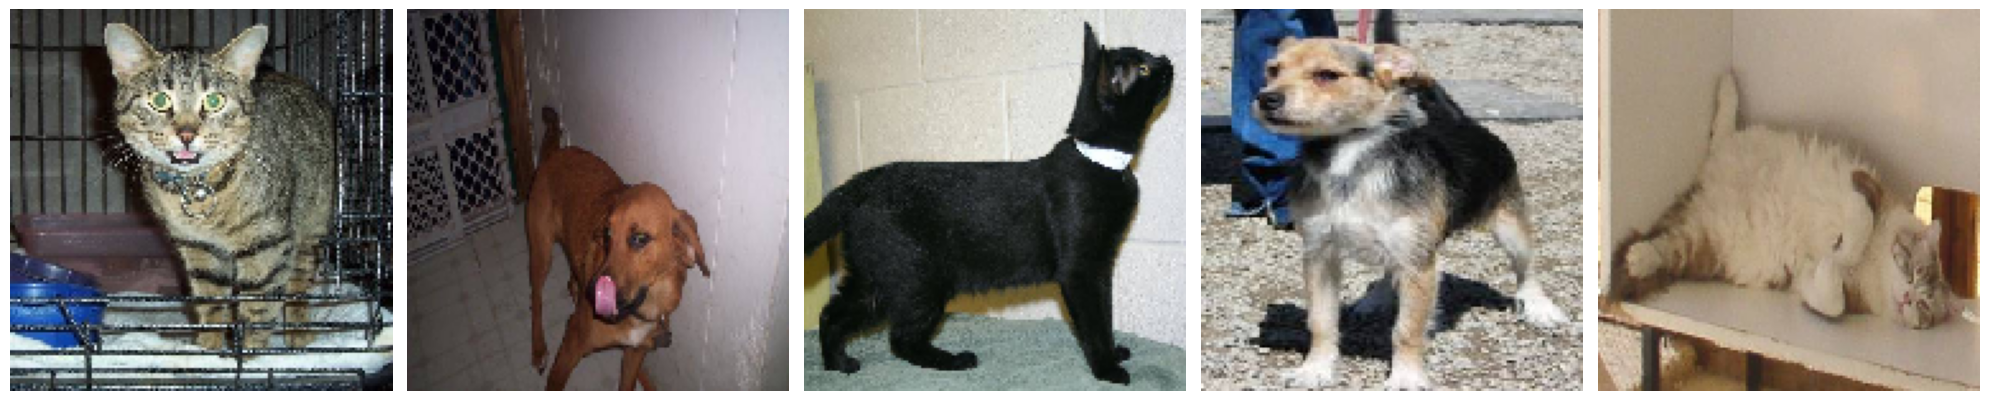

In [5]:
# 4
def plotImages(images_arr, probs=None):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax, idx in zip(images_arr, axes, range(len(images_arr))):
        ax.imshow(img)
        if probs is not None:
            ax.set_title(f'{probs[idx]*100:.1f}% sure')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of training images and plot 5 random ones.
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [6]:
# 5
# Create an ImageDataGenerator with random transformations for data augmentation
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Recreate the training data generator using augmented data
train_data_gen = train_image_generator.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)



Found 2000 images belonging to 2 classes.


Found 2000 images belonging to 2 classes.


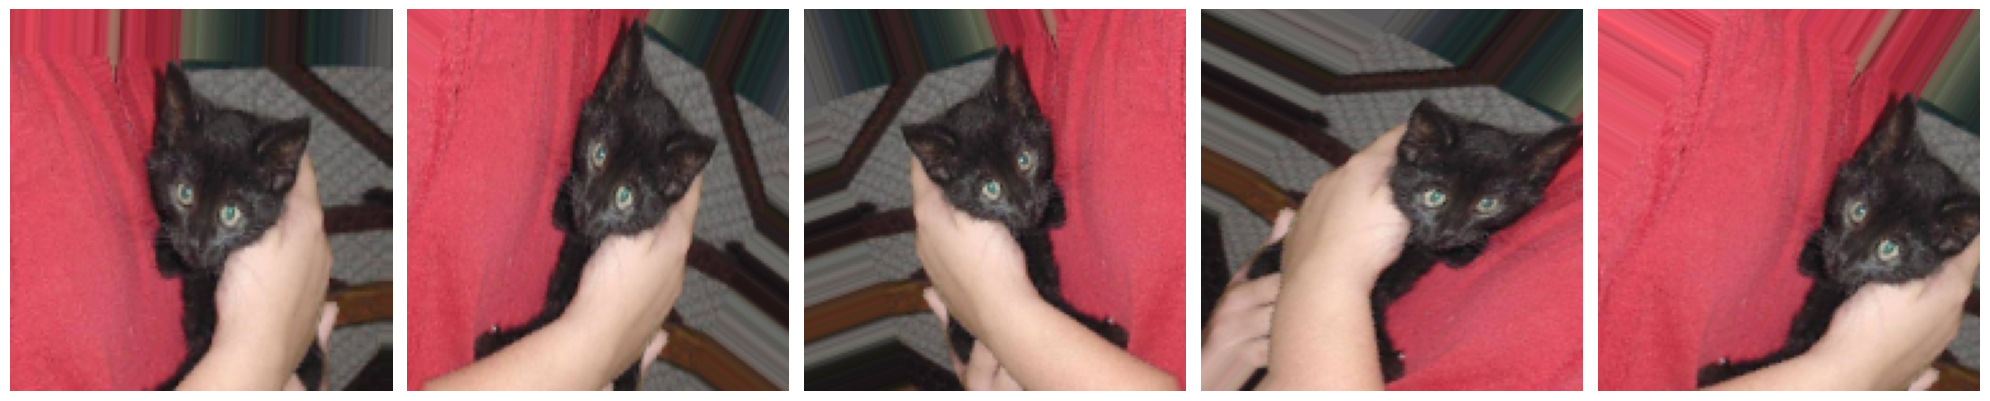

In [7]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [8]:
# 7
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                           input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification (cat vs. dog)
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 8
epochs = 20
steps_per_epoch = train_data_gen.n // train_data_gen.batch_size
validation_steps = validation_data_gen.n // validation_data_gen.batch_size

history = model.fit(
    train_data_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_data_gen,
    validation_steps=validation_steps
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4877 - loss: 0.7212 - val_accuracy: 0.5726 - val_loss: 0.6925
Epoch 2/20
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5703 - loss: 0.6926

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.5703 - loss: 0.6926 - val_accuracy: 0.5786 - val_loss: 0.6923
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5375 - loss: 0.6917 - val_accuracy: 0.5131 - val_loss: 0.6810
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.5625 - loss: 0.6725 - val_accuracy: 0.6200 - val_loss: 0.6716
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5517 - loss: 0.6854 - val_accuracy: 0.6139 - val_loss: 0.6703
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.5234 - loss: 0.6861 - val_accuracy: 0.6079 - val_loss: 0.6665
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5854 - loss: 0.6704 - val_accuracy: 0.6179 - val_loss: 0.6490
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.5547 - loss: 0.6927 - val_accuracy: 0.6280 - val_loss: 0.6402
Epoch 9/20


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
TEST_DIR = os.path.join(base_dir, 'test', 'unknown')
test_data_gen = basic_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode=None,
    shuffle=False
)


In [ ]:
# Generate predictions on test images
predictions = model.predict(test_data_gen, steps=test_data_gen.n)
# Convert predictions (floats between 0 and 1) to binary outcomes (0 or 1)
probabilities = [int(round(pred[0])) for pred in predictions]

# To plot, we first need to load the images.
# Since test_data_gen uses flow_from_directory, we can grab the image paths:
test_image_paths = test_data_gen.filepaths
# Load and rescale the images manually for plotting
test_images = [tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
               for img_path in test_image_paths]
test_images = [tf.keras.preprocessing.image.img_to_array(img)/255.0 for img in test_images]

# Plot test images with prediction probabilities
plotImages(test_images, probabilities)


In [ ]:
# (This cell may contain code to compute overall test accuracy if labels are available or simply indicate challenge completion.)
# For example, if you have the true labels for the test set, you could compute:
# true_labels = ...  (obtain from the dataset or a separate file)
# test_accuracy = np.mean(np.array(probabilities) == np.array(true_labels))
# print(f'Test accuracy: {test_accuracy*100:.1f}%')

print("Challenge completed. If your test predictions roughly match the accuracy shown in the plots, you passed!")

